In [1]:
!pip3 install tensorflow

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [3]:
class Predictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(Predictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
def prepare_country_data(country_data, sequence_length=5):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(country_data.reshape(-1, 1))
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])
    
    return np.array(X), np.array(y), scaler


In [6]:
def train_model(X, y, epochs=200):
    # Create dataset and dataloader
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Initialize model
    model = Predictor(input_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    
    return model

In [20]:
def predict_future(model, last_sequence, scaler, n_future=7):  # Changed to 7 years
    model.eval()
    current_sequence = last_sequence.copy()
    predictions = []
    
    with torch.no_grad():
        for _ in range(n_future):  # Will now predict 7 years
            sequence = torch.FloatTensor(current_sequence).unsqueeze(0)
            pred = model(sequence)
            predictions.append(pred.numpy())
            current_sequence = np.vstack((current_sequence[1:], pred.numpy()))
    
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()

In [16]:
df = pd.read_csv('../datasets/energy.csv')
df.head()
df.replace("..", pd.NA, inplace=True)
# Forward fill first, then backward fill to handle any remaining NAs at the start
df.rename(columns={'Country Name': 'Country'}, inplace=True)
df.drop(columns=['YR2022', 'YR2023'], inplace=True)
df = df.ffill().bfill()
df.head()

,Country,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021
0,Argentina,2.21103916447582,0.78997913166528,0.568187363007616,0.676135028048864,1.43730115442118,1.53656088925892,0.805650721774117,1.59471633197215
1,Australia,0.755451088942237,0.567565619466884,0.591410295226177,0.760358992143208,1.14049132500834,1.31732811944483,1.1162720977283,1.6313907314568
2,Brazil,1.39876331607307,0.857685698468755,0.686699294180488,0.934976537711634,1.5802963493344,1.44608781006584,0.949585951805012,2.26355193351451
3,China,1.17449560810056,0.55146891809536,0.468471119066501,0.582954445963903,0.704281724834458,0.554702096120324,0.361833602387154,0.689430074246557
4,France,0.00701751945317788,0.00394674875841994,0.00301090345845521,0.00404255730613459,0.00676725037994716,0.00543453180331309,0.00264417156034399,0.00550683481013504


In [17]:
cols = [col for col in df.columns if 'YR' in col]
print(cols)
    
sequence_length = 7
predictions_by_country = {}
selected_countries = ['United States', 'China', 'Japan', 'Germany', 'United Kingdom']

['YR2014', 'YR2015', 'YR2016', 'YR2017', 'YR2018', 'YR2019', 'YR2020', 'YR2021']


In [21]:
for country in df['Country']:
        print(f"\nTraining model for {country}")
        
        # Get country data
        country_data = df[df['Country'] == country][cols].values.flatten()

        country_data = country_data.astype(float)
        
        # Prepare data
        X, y, scaler = prepare_country_data(country_data, sequence_length)
        
        if len(X) > 0:  # Check if we have enough data
            # Train model
            model = train_model(X, y)
            
            # Make predictions
            last_sequence = scaler.transform(country_data[-sequence_length:].reshape(-1, 1))
            predictions = predict_future(model, last_sequence, scaler)
            predictions_by_country[country] = predictions
    


Training model for Argentina
Epoch [50/200], Loss: 0.0008
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for Australia
Epoch [50/200], Loss: 0.0063
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for Brazil
Epoch [50/200], Loss: 0.0065
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for China
Epoch [50/200], Loss: 0.0000
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for France
Epoch [50/200], Loss: 0.0049
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for Germany
Epoch [50/200], Loss: 0.0056
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for India
Epoch [50/200], Loss: 0.0007
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epo

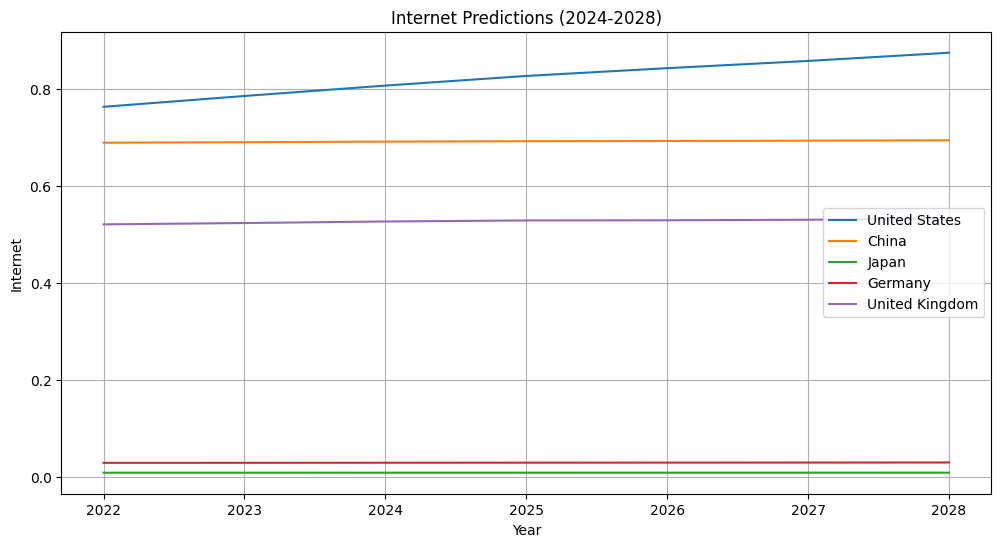


Predicted Internet (2024-2028):

United States:
2022: $0.76
2023: $0.78
2024: $0.81
2025: $0.83
2026: $0.84
2027: $0.86
2028: $0.87

China:
2022: $0.69
2023: $0.69
2024: $0.69
2025: $0.69
2026: $0.69
2027: $0.69
2028: $0.69

Japan:
2022: $0.01
2023: $0.01
2024: $0.01
2025: $0.01
2026: $0.01
2027: $0.01
2028: $0.01

Germany:
2022: $0.03
2023: $0.03
2024: $0.03
2025: $0.03
2026: $0.03
2027: $0.03
2028: $0.03

United Kingdom:
2022: $0.52
2023: $0.52
2024: $0.53
2025: $0.53
2026: $0.53
2027: $0.53
2028: $0.53


In [22]:
plt.figure(figsize=(12, 6))
for country in selected_countries:
    if country in predictions_by_country:
        plt.plot(range(2022, 2029), predictions_by_country[country], label=country)
plt.title('Internet Predictions (2024-2028)')
plt.xlabel('Year')
plt.ylabel('Internet')
plt.legend()
plt.grid(True)
plt.show()
    
    # Print predictions for selected countries
print("\nPredicted Internet (2024-2028):")
for country in selected_countries:
    if country in predictions_by_country:
        print(f"\n{country}:")
        for year, pred in zip(range(2022, 2029), predictions_by_country[country]):
            print(f"{year}: ${pred:,.2f}")

In [23]:
# Export predictions to CSV
predictions_df = pd.DataFrame()
predictions_df['Country'] = list(predictions_by_country.keys())

for year in range(2022, 2029):
    year_predictions = []
    for country in predictions_df['Country']:
        if country in predictions_by_country:
            year_predictions.append(predictions_by_country[country][year-2022])
        else:
            year_predictions.append(None)
    predictions_df[f'{year} Energy'] = year_predictions

predictions_df.to_csv('../lstm_datasets/energy_prediction.csv', index=False)
print("\nPredictions exported to lstm_datasets/energy_prediction.csv")


Predictions exported to lstm_datasets/energy_prediction.csv
